# Actividad Integradora 2

## Analisis de sentimiento de tweets. 

Basado en los tutoriales de Sentdex: https://www.youtube.com/playlist?list=PLQVvvaa0QuDf2JswnfiGkliBInZnIC4HL 

Importamos las librerias que vamos a utilizar.

In [1]:
import nltk
import random
#from nltk.corpus import movie_reviews
from nltk.classify.scikitlearn import SklearnClassifier
import pickle
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from nltk.classify import ClassifierI
from nltk.tokenize import word_tokenize
from statistics import mode
from collections import Counter


In [2]:
#Por alguna razon si se corre esto genera algun bug que baja el accuracy.

#Descubrimos el encoding de nuestro dataset.
#import chardet

#with open("positive.txt","rb") as rawdata:
#    result = chardet.detect(rawdata.read(100000))

#print(result)

#encod = result['encoding']

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


In [2]:
#Abrimos el archivo con los textos
short_pos = open("positive.txt","r",encoding = "Windows-1252").read()
short_neg = open("negative.txt","r",encoding = "Windows-1252").read()



In [3]:
all_words = []
documents = []

#  j is adject, r is adverb, and v is verb
#allowed_word_types = ["J","R","V"]
allowed_word_types = ["J"]


for p in short_pos.split('\n'):
    documents.append( (p, "pos") ) #Adjuntamos la review a la lsita documents con su label en tuplas
    words = word_tokenize(p) # Se tokeniza la review
    pos = nltk.pos_tag(words) # Se identifica el tipo de palabra 
    for w in pos: #Se dejan solo el tipo de palabra permitido
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())


for p in short_neg.split('\n'):
    documents.append( (p, "neg") )
    words = word_tokenize(p)
    pos = nltk.pos_tag(words)
    for w in pos:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())

In [4]:
all_words = nltk.FreqDist(all_words)

all_words.most_common(15)

[('good', 369),
 ('more', 331),
 ('little', 265),
 ('funny', 245),
 ('much', 234),
 ('bad', 234),
 ('best', 208),
 ('new', 206),
 ('own', 185),
 ('many', 183),
 ('most', 167),
 ('other', 167),
 ('great', 160),
 ('big', 156),
 ('few', 139)]

#### Escribimos algunas funciones y clases utilizadas en los tutoriales.

In [5]:
word_features = list(all_words.keys())[:5000] #Agarramos las 5000 palabras mas comunes


#Convierte la lista de palabras a una lista de true y false dependiento si alguna de las 3000 palabras mas comunes 
# se encuentra en el review
def find_features(document):
    words = word_tokenize(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features


#Crea una lista de tuplas donde hay un diccionario donde las llaves son las 3000 palabras mas comunes y los valores son true
#o false dependiendo si se encuentra la palabra en el riview, el otro valor de la tubla es el label de neg o pos.
featuresets = [(find_features(rev), category) for (rev, category) in documents]

random.shuffle(featuresets)

In [7]:
#Clase para juntar todos los clasificadores.
class VoteClassifier(ClassifierI): #Inheritance from the ClassifierI class
    def __init__(self,*classifiers): #pass a list of classfiers
        self._classifiers = classifiers

    def find_mode(self,votes):# Se lo tuve que agregar porque ocurria un error cuando los dos valores tenian los mismos votos.
        c = Counter(votes)
        return (c.most_common(1))[0][0]
        
    def classify(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        return self.find_mode(votes)

    def confidence(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)

        choice_votes = votes.count(self.find_mode(votes))
        conf = choice_votes / len(votes)
        return conf

In [8]:
#Dividimos en train y test sets
testing_set = featuresets[10000:]
training_set = featuresets[:10000]

#### Utilizamos los modelos que utilizo sentdex en su tutorial

In [9]:
# AVISO!!
# Esta celda tarda varios minutos debido a que se estan entrenando los modelos 
# Aprox 

#El original de nltk
classifier = nltk.NaiveBayesClassifier.train(training_set)
print("Original Naive Bayes Algo accuracy percent:", (nltk.classify.accuracy(classifier, testing_set))*100)
classifier.show_most_informative_features(15)

#Modelos de sklearn
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_classifier, testing_set))*100)

BernoulliNB_classifier = SklearnClassifier(BernoulliNB())
BernoulliNB_classifier.train(training_set)
print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BernoulliNB_classifier, testing_set))*100)

LogisticRegression_classifier = SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train(training_set)
print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogisticRegression_classifier, testing_set))*100)

LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(training_set)
print("LinearSVC_classifier accuracy percent:", (nltk.classify.accuracy(LinearSVC_classifier, testing_set))*100)

#Tarda mucho en converger
#NuSVC_classifier = SklearnClassifier(NuSVC())
#NuSVC_classifier.train(training_set)
#print("NuSVC_classifier accuracy percent:", (nltk.classify.accuracy(NuSVC_classifier, testing_set))*100)


voted_classifier = VoteClassifier(
                                  LinearSVC_classifier,
                                  MNB_classifier,
                                  BernoulliNB_classifier,
                                  LogisticRegression_classifier)

print("voted_classifier accuracy percent:", (nltk.classify.accuracy(voted_classifier, testing_set))*100)

Original Naive Bayes Algo accuracy percent: 71.6867469879518
Most Informative Features
              engrossing = True              pos : neg    =     21.0 : 1.0
                 generic = True              neg : pos    =     16.3 : 1.0
                mediocre = True              neg : pos    =     15.7 : 1.0
               inventive = True              pos : neg    =     15.0 : 1.0
                  boring = True              neg : pos    =     14.7 : 1.0
                    flat = True              neg : pos    =     14.6 : 1.0
                    warm = True              pos : neg    =     13.0 : 1.0
                    dull = True              neg : pos    =     12.6 : 1.0
             mesmerizing = True              pos : neg    =     11.0 : 1.0
                  stupid = True              neg : pos    =     11.0 : 1.0
               wonderful = True              pos : neg    =     11.0 : 1.0
                    chan = True              neg : pos    =     10.3 : 1.0
             

In [10]:
def sentiment(text):
    feats = find_features(text)
    return voted_classifier.classify(feats),voted_classifier.confidence(feats)

In [11]:
! pip install tweepy

     |████████████████████████████████| 146 kB 2.6 MB/s 
ERROR: Could not find a version that satisfies the requirement twitterapistuff
ERROR: No matching distribution found for twitterapistuff


### Twitter Live Sentiment Analysis 

In [11]:
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import json
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import time


In [12]:
#consumer key, consumer secret, access token, access secret.
ckey="C0MsQRVLkMGGF4toOABEdxb7k"
csecret="miIUZX0JIj5UlIVQ5mj6h81RelQpe63kZA9YfjM04rwJd04eHM"
atoken="1019722469278736386-CtB43E6YXm2E8EB63IeSPGtlsKI3NI"
asecret="dydK5z0e5EYieS2IBvgZNPT0lTFRW3MQgXBRrKV4BpIk0"


class listener(StreamListener):
	def on_data(self, data):
		all_data = json.loads(data)

		tweet = all_data["text"]
		sentiment_value, confidence = sentiment(tweet)
		print(tweet, sentiment_value, confidence)

		if confidence*100 >= 80:
			output = open("twitter-out.txt","a")
			output.write(sentiment_value)
			output.write('\n')
			output.close()

		return True
		
	def on_error(self, status):
		print(status)

auth = OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)

twitterStream = Stream(auth, listener())
twitterStream.filter(track=["happy"])

RT @parkjamjam_kr: HAPPY JIMIN DAY SUPPORT 

건대 커먼그라운드 건물 전체 래핑
-지민 테마파크(My Serendipity)

21.10.9-21.10.10

지민이의 27번째 생일을 맞이하여 국내 최대 컨테이너 팝… neg 1.0
@jessicakevibes It's boring, come to me, I'll make you happy and comfortable at me Twitter🍑 neg 0.75
RT @adviceburner: don't make someone feel bad for being excited about something that makes them happy neg 1.0
RT @UNDP: Our future depends on solidarity, trust &amp; our ability to work together to achieve the #GlobalGoals.

We are happy to join @antoni… pos 1.0
Aqua smiled and happily closed her eyes, happy to know someone found her impressive,

"Not exactly but, it can neve… https://t.co/fU6iAnWqEV pos 1.0
RT @HeidiOlsonJone2: Good Thursday morning! Our last sunny day for awhile. I have a family wedding later today. Some happy, normal stuff co… pos 1.0
RT @Jinan_JKT48: thanks for today! tadi aku bacain surat untuk Celine 🥺 once again, happy bday 🎂 https://t.co/HDmZjThisH pos 1.0
We are so lucky to have such a fabulous team of TAs and a wo

KeyError: 'text'

/Users/Emi/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/matplotlib/animation.py:974: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  'Animation was deleted without rendering anything. This is '


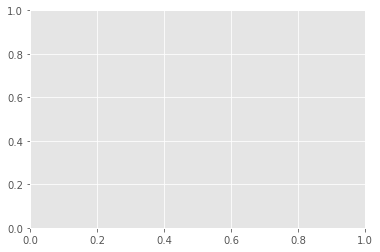

In [23]:
#Parte para graficar
style.use("ggplot")

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

def animate(i):
    pullData = open("twitter-out.txt","r").read()
    lines = pullData.split('\n')

    xar = []
    yar = []

    x = 0
    y = 0

    for l in lines[-200:]:
        x += 1
        if l == "pos":
            y += 1
        elif l == "neg":
            y -= 1

        xar.append(x)
        yar.append(y)
        
    ax1.clear()
    return ax1.plot(xar,yar)

ani = animation.FuncAnimation(fig, animate, interval=1000)
plt.show()

In [16]:
pullData = open("twitter-out.txt","r").read()
lines = pullData.split('\n')
lines

['pos',
 'pos',
 'neg',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'pos',
 'neg',
 'neg',
 'neg',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'neg',
 'pos',
 'neg',
 'pos',
 'neg',
 'neg',
 'neg',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'neg',
 'neg',
 'pos',
 'neg',
 'pos',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'pos',
 'pos',
 'neg',
 'pos',
 'neg',
 'pos',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'neg',
 'neg',
 'neg',
 'pos',
 'pos',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'pos',
 'pos',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'pos',
 'pos',
 'neg',
 'pos',
 'neg',
 'pos',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'pos',
 'neg',
 'neg',
 'pos',
 'pos',
 'neg',
 'pos',
 'neg',
 'pos',
 'neg',
